In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


import sys
sys.path.append('../../..')
from batchflow.opensets import Imagenette160
from batchflow import Pipeline, B, V, C, W

from batchflow.models.torch import ResNet34, ResBlock, SelfAttention
from batchflow.models.torch.layers import ConvBlock

from batchflow.models.metrics import ClassificationMetrics
from batchflow.research import Research, Option, Results, KV, RP, REU, RI
from batchflow.utils import plot_results_by_config, show_research, print_results

In [2]:
# Global constants
NUM_ITERS = 15000                               # number of iterations to train each model for
N_REPS = 4                                      # number of times to repeat each model train
RESEARCH_NAME = 'research'                      # name of Research object
DEVICES = [5, 6, 7]                             # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 50

dataset = Imagenette160()                       # dataset to train models on

In [3]:
class SAResBlock(nn.Module):
    def __init__(self, inputs=None, **kwargs):
        super(SAResBlock, self).__init__()

        self.layer = ConvBlock({'base': ResBlock, **kwargs},
                               {'base': SelfAttention},
                               inputs=inputs)
        
    def forward(self, x):
        return self.layer(x)

In [4]:
domain = (Option('body', [KV({'encoder/blocks/base':ResBlock, 'encoder/blocks/se': False},
                             'ResBlock'),
                          KV({'encoder/blocks/base':ResBlock, 'encoder/blocks/se': True},
                             'SEResBlock'),
                          KV({'encoder/blocks/base':SAResBlock},
                             'SAResBlock'), 
                          KV({'encoder/blocks/base':SAResBlock, 'encoder/blocks/se': True},
                             'SESAResBlock'),
                         ]))

In [5]:
config = {
    'inputs/labels/classes': 10,
    'body': C('body'),
    'head/layout': 'cV',
    'device': C('device'),
}

In [6]:
train_root = (dataset.train.p      
                  .crop(shape=(160, 160), origin='center')
                  .to_array(channels='first', dtype=np.float32)
                  .run_later(64, n_epochs=None, drop_last=True,
                             shuffle=True)
                   )

train_pipeline = (Pipeline()
                  .init_variable('loss')
                  .init_model('dynamic', ResNet34, 'my_model', config=config) 
                  .train_model('my_model', B('images'), B('labels'), 
                               fetches='loss', save_to=V('loss'))
                 )

test_pipeline = (dataset.test.p
                 .import_model('my_model', C('import_from'))
                 .init_variable('true', [])
                 .update(V('true', mode='a'), B.labels) 
                 .init_variable('predictions', [])
                 .crop(shape=(160, 160), origin='center')
                 .to_array(channels='first', dtype=np.float32)
                 .predict_model('my_model', B('images'), fetches='predictions',
                                save_to=V('predictions', mode='a'))
                 .run_later(128, n_epochs=1, drop_last=False,
                            shuffle=True)
                 )

In [7]:
def acc(iteration, experiment):
    pipeline = experiment.pipeline
    pred = np.concatenate(pipeline.v('predictions'))
    true = np.concatenate(pipeline.v('true'))
    accuracy = ClassificationMetrics(true, pred, fmt='logits',
                                     num_classes=10, axis=1).accuracy()
    return accuracy

In [8]:
research = (Research()
            .init_domain(domain, n_reps=N_REPS)
            .add_pipeline(root=train_root, branch=train_pipeline, variables='loss',
                          name='train_ppl', logging=True)
            .add_pipeline(test_pipeline, name='test_pplf', execute=TEST_FREQUENCY,
                          run=True, import_from=RP('train_ppl'))
            .add_callable(acc, returns='acc_vall', name='acc_fn', execute=TEST_FREQUENCY,
                          iteration=RI(), experiment=REU('test_ppl')))

In [9]:
research.run(NUM_ITERS, name=RESEARCH_NAME,
             devices=DEVICES, workers=WORKERS,
             bar=True)

Domain updated: 0: 100%|██████████| 240000/240000.0 [8:08:27<00:00,  8.19it/s]


In [10]:
%%time
results = Results(path=RESEARCH_NAME, concat_config=True)
# results = research.load_results(concat_config=True)

CPU times: user 3min, sys: 152 ms, total: 3min
Wall time: 3min


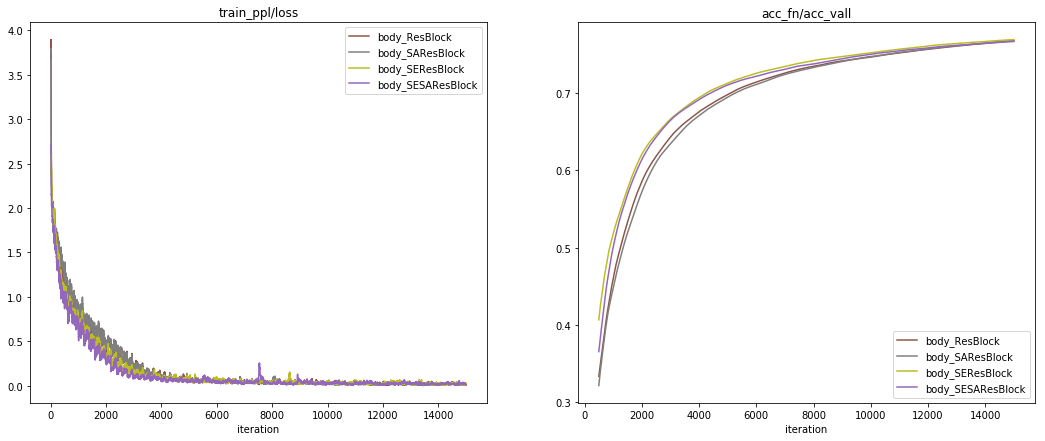

In [19]:
show_research(results.df, layout=['train_ppl/loss', 'acc_fn/acc_vall'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=False, rolling_window=10)

In [21]:
print_results(results.df, 'acc_fn/acc_vall', False, ascending=True, n_last=100)

,acc_fn_3,acc_fn_1,acc_fn_0,acc_fn_2,acc_fn_mean,acc_fn_std
body_ResBlock,0.763751,0.766668,0.770075,0.772159,0.768163,0.003215
body_SAResBlock,0.771357,0.765105,0.773229,0.764361,0.768513,0.003847
body_SEResBlock,0.775786,0.764330,0.771806,0.766212,0.769534,0.004538
body_SESAResBlock,0.773874,0.765266,0.766781,0.762153,0.767018,0.004295
